# Verification of DBScan clustering of Precipitation Events

## Objective: 
The DBSCAN algorithm was used to group observations from TRMM (from the swath paths) into 'rain events' based on the location and time of rain observations. There hyperparameters were used in this process: the minimum number of observations needed to be considered and 'event', the distance threshold underwhich observations are clustered together, and the conversion of time into a equivalent spatial distance when calculating the distance between observations.

Here, the objective is to evaluate whether the DBSCAN algorithm is producing sensical results. A qualititave approach is taken by comparing snapshots of the clustered output to other satellite products at similar points in time. Both output from the 3-Hour Real Time TRMM Multi-satellite Precipitation Analysis, a gridded data product that includes TRMM observations as well as those from other satellites (https://pmm.nasa.gov/sites/default/files/document_files/3B4XRT_doc_V7_180426.pdf) and the MODIS satellite (access from here: https://ladsweb.modaps.eosdis.nasa.gov/search/) were used.

I've been adjusting the maximum distance (eps) allowed to group a point in a cluster, and it seems that 150 km is making more sense (qualitatively) than the previously used value. Below are the same figures as before, but with the new metric for eps.

### Loading in the Data
We start by importing modules, as well as downloading the dbscan output from S3 and importing it into the notebook to work with.

In [1]:
#import the different packages used throughout
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import math
import datetime
import boto3
from os.path import expanduser
import os
import json
import glob
from scipy.stats import skew
import cartopy.crs as ccrs
from pyhdf import SD

%matplotlib inline

def load_Data():
    #download the compiled dbscan output and return the xarray data
    home = expanduser("~")

    with open(os.path.join(home,'creds.json')) as creds_file:
        creds_data = json.load(creds_file)

    #Access from S3
    s3 = boto3.resource('s3',aws_access_key_id=creds_data['key_id'],
             aws_secret_access_key=creds_data['key_access'],region_name='us-west-2')
    bucket = s3.Bucket('himatdata')
    home = os.getcwd()

    #download the file (note this is a big, 10+ GB file)
    bucket.download_file('Trmm/EPO/Cluster_results_March5/DB_compiled_Clustered_Data.nc4',
                         os.path.join(os.path.join(home,'S3_downloads/DB_compiled_Clustered_Data.nc4')))
    #open the local copy
    F = xr.open_dataset('S3_downloads/DB_compiled_Clustered_Data.nc4')

    return F


F = load_Data()


### Exploring a Specific Day
We looked at the output from January 1, 2009, to get a sense of what observations were being clustered together. First clusters with observations on that day are extracted from the dataset and plotted. We also look at when those observations were taken to understand both the spatial component of the clustering as well as the temporal component.

In [59]:
#helper functions for the analysis

def extract_day(year,month,day,F):
    #function that extracts all clusters in F with at least one observations on a given day
    
    #get the indices of the time variabile for the date of interest
    ind = (F.Time.dt.year==year) & (F.Time.dt.month==month) & (F.Time.dt.day==day)
    #get the unique cluster numbers that correspond to those times
    db_ind = np.unique(F.DBLabel[ind])
    
    db_ind = db_ind[db_ind>-1]

    #create empty matrices to hold the subset of data of interes
    subset_dblabels = []
    subset_lat = []
    subset_lon = []
    subset_time = []

    #for each cluster that falls on that day, extract some data and append it to the array
    for i in range(len(db_ind)):
        ind = F.DBLabel==db_ind[i]
        subset_dblabels = np.append(subset_dblabels,F.DBLabel[ind])
        subset_lat = np.append(subset_lat,F.Latitude[ind])
        subset_lon = np.append(subset_lon,F.Longitude[ind])
        subset_time = np.append(subset_time,np.array(F.Time[ind]-np.datetime64(str(year)+'-'+str(month).zfill(2)+'-'+str(day).zfill(2)),'float')/3.6e12)
        #time is converted to hours
    
    return subset_dblabels, subset_lat, subset_lon, subset_time


def plot_clusters_subset(subset_dblabels,subset_lon,subset_lat,subset_time, view='merc'):
    #function that creates a figure with two subplots - one showing observations colored by cluster and the 
    #other showing observations colored by time since midnight Jan 1 2009 the observations were made in hours
    
    #get the cluster numbers
    uniqLabels = np.unique(subset_dblabels)
    print('number of cluster: ', len(uniqLabels))
        
    #region of plot
    bbox = [-40,40,150,260]
    
    #spacing of parallels and meridians in plot
    parallels = np.arange(-60.,81,10.)
    verts = np.arange(0.,360,25.)
    
    fig = plt.figure(figsize=(20,9))
    plt.subplot(1,2,1)
    
    #if the close up view for MODIS comparision, change some values
    if view == 'cass':
        bbox = [0,22,-176,-149]
        parallels = np.arange(0.,20,5.)
        verts = np.arange(-175.,-150,5.)
        # Define the projection, scale, the corners of the map, and the resolution.        
        m = Basemap(projection='cass',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i',
            lon_0=(bbox[2]+bbox[3])/2,lat_0=(bbox[0]+bbox[1])/2)
    else:
        # Define the projection, scale, the corners of the map, and the resolution.
        m = Basemap(projection=view,llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
                    llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
    cmap = plt.get_cmap('tab20')

    # Draw coastlines and put in parallels and meridians
    m.drawcoastlines()
    m.drawparallels(parallels,labels=[False,True,True,False]);
    m.drawmeridians(verts,labels=[False,True,True,False]);

    #for each cluster, plot the observations in it as a scatter plot
    for ii in range(20,40): #range(len(uniqLabels)):
        color_interp = np.interp(ii,[0,15],[0,20])#len(uniqLabels)],[-1,1])
        m.scatter(np.array(subset_lon[subset_dblabels==uniqLabels[ii]]), 
                  np.array(subset_lat[subset_dblabels==uniqLabels[ii]]), 
                  latlon=True,marker='o',color=cmap(ii-20),s=5)

    #for each cluster, plot the observations in it as a scatter plot
    for ii in range(0,20): #range(len(uniqLabels)):
        color_interp = np.interp(ii,[0,15],[0,20])#len(uniqLabels)],[-1,1])
        m.scatter(np.array(subset_lon[subset_dblabels==uniqLabels[ii]]), 
                  np.array(subset_lat[subset_dblabels==uniqLabels[ii]]), 
                  latlon=True,marker='o',color=cmap(ii),s=5)
    
    plt.subplot(1,2,2)
    if view == 'cass':
        # Define the projection, scale, the corners of the map, and the resolution.        
        m = Basemap(projection='cass',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i',
            lon_0=(bbox[2]+bbox[3])/2,lat_0=(bbox[0]+bbox[1])/2)
    else:
        # Define the projection, scale, the corners of the map, and the resolution.
        m = Basemap(projection=view,llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
                    llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
        
    # Draw coastlines and put in parallels and meridians
    m.drawcoastlines()
    m.drawparallels(parallels,labels=[False,True,True,False]);
    m.drawmeridians(verts,labels=[False,True,True,False]);

    im = m.scatter(np.array(subset_lon),np.array(subset_lat), latlon=True,marker='o',
                   c=subset_time,s=5)

    #add a colorbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax, label='Time since Jan 1, 2009 [hours]')


number of cluster:  40


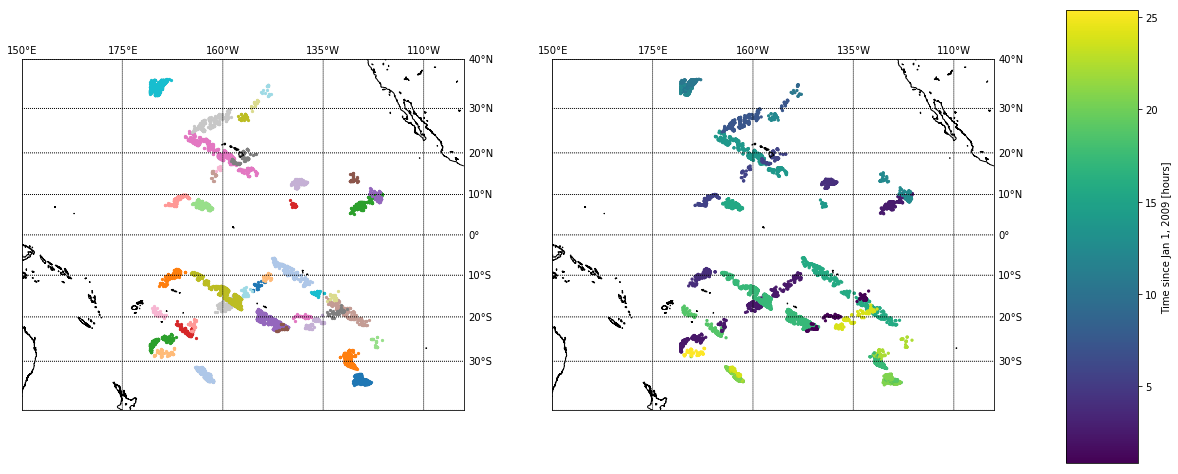

In [74]:
subset_dblabels, subset_lat, subset_lon, subset_time = extract_day(2009,1,1,F)
plot_clusters_subset(subset_dblabels,subset_lon,subset_lat,subset_time)

Just visually, things are making more sense than before. Although you still have the swath nature of observations (as will always be the case) you are no longer getting groupings across wide ranges in time. There are a lot more clusters than before, and they are tighter. There is one area in the southern hemisphere where I can't understand why 3 clusters were made as opposed to one (around 10-15S, 150W ther is a light blue, dark blue, and light orange cluster very close together and within the same swath) - I can't figure out what would have driven the 'distance' metric beyond 150 km for those points.

### Comparision with MODIS Image
How does this visually compare to observations from MODIS? Is it grouping things together that would align with an image from MODIS? The image I am comparing to was taken on January 1, 2009 (in the evening, I believe 21:25). The TRMM satellite does not pass the same point at the exact time, but there should be some room for a visual comparison.

#### The DBSCAN Results
For comparision the DBSCAN results are also plotted on a similar map view below

number of cluster:  40


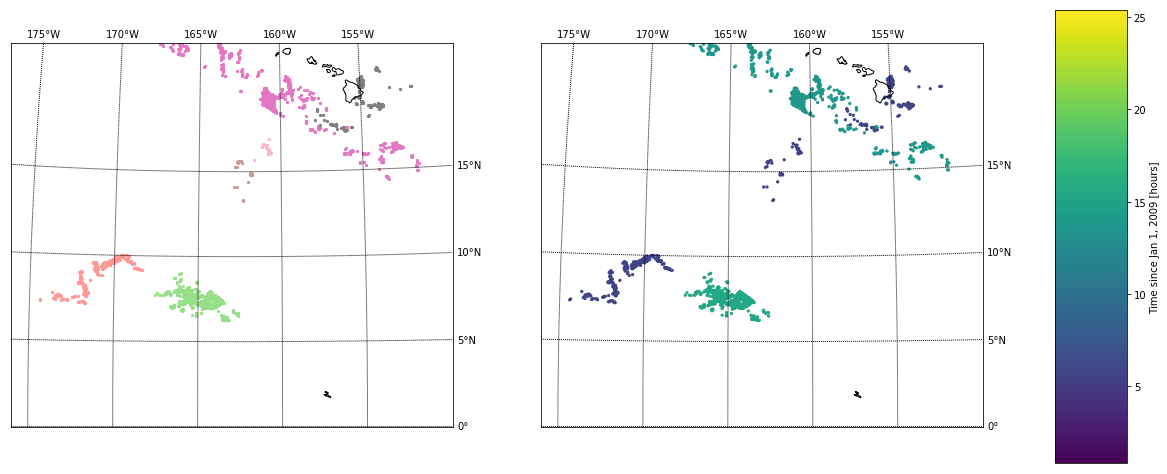

In [91]:
plot_clusters_subset(subset_dblabels,subset_lon,subset_lat,subset_time,view='cass')

The TRMM data is picking up rain near this region a few hours ahead of the MODIS data (around 13 and 5 rather than 21 UTC in both the pink and gray cluster respectively). Since the TRMM data is from much earlier in the day, I also looked at January 2nd to see if I could get something closer in time.

number of cluster:  43


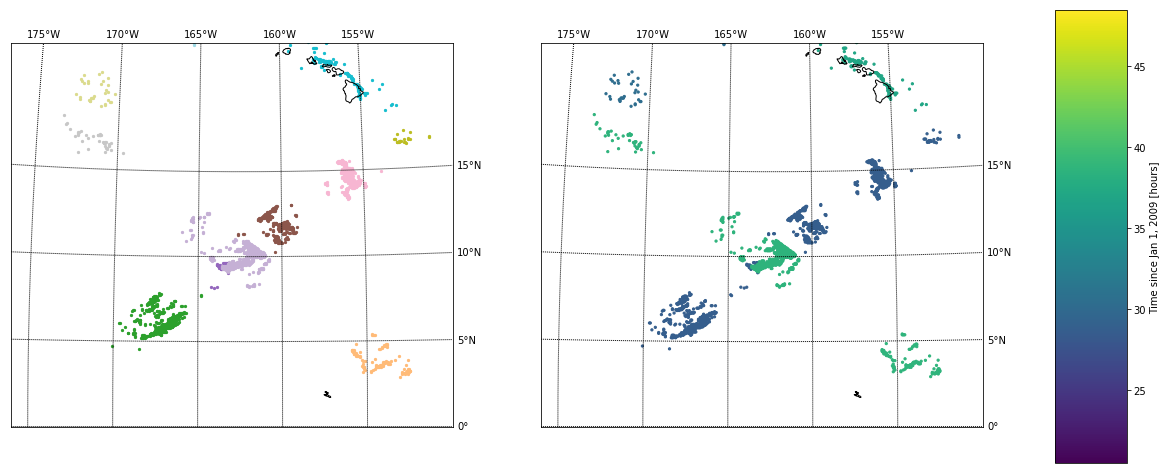

In [81]:
subset_dblabels, subset_lat, subset_lon, subset_time = extract_day(2009,1,2,F)
plot_clusters_subset(subset_dblabels,subset_lon,subset_lat,subset_time,view='cass')

The cluster near Hawaii at close to the time of the MODIS data (pink) is narrower than the cloud suggests, but that difference largely stems from the swath width that misses part of the larger area. For a better comparison, below the TRMM cluster is overlain on the MODIS data.

In [103]:
def plot_MODIS_comparision(subset_dblabels,subset_lon,subset_lat,subset_time):
    #load modis data
    for file in glob.glob('MODIS/M*.hdf'):
        df = SD.SD(file)
    
    CR = df.select('Cirrus_Reflectance')
    lat = df.select('Latitude')
    lon = df.select('Longitude')

    #define region to plot
    bbox = [0,22,-176,-149]
    parallels = np.arange(0.,20,5.)
    verts = np.arange(-175.,-150,5.)

    #only look at clusters in NH and within ~5 hours of MODIS image
    inds = subset_dblabels[(subset_time<29) & (subset_lat>5)]
    uniqLabels = np.unique(inds)
    fig = plt.figure(figsize=(10,9))
    m = Basemap(projection='cass',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i',
            lon_0=(bbox[2]+bbox[3])/2,lat_0=(bbox[0]+bbox[1])/2)


    # Draw coastlines and put in parallels and meridians
    m.drawcoastlines()
    m.drawparallels(parallels,labels=[False,True,True,False]);
    m.drawmeridians(verts,labels=[False,True,True,False]);

    #plot the MODIS data
    m.contourf(lon[:],lat[:],CR[::5,5::5],latlon=True,cmap = plt.get_cmap('Greys'))
    cmap = plt.get_cmap('tab10')

    #plot the clusters
    for ii in range(len(uniqLabels)):
        m.scatter(np.array(subset_lon[subset_dblabels==uniqLabels[ii]]), 
                  np.array(subset_lat[subset_dblabels==uniqLabels[ii]]), 
                  latlon=True,marker='o',color=cmap(2*ii),s=5)

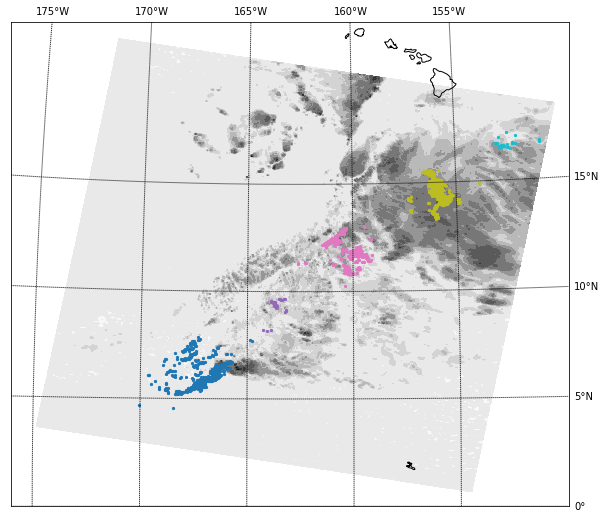

In [104]:
plot_MODIS_comparision(subset_dblabels,subset_lon,subset_lat,subset_time)

The clusters shown were observed within about 5 hours of when the MODIS image was taken. The swath of TRMM narrows the region that can be sampled, but it shows rain close to where clouds in MODIS were observed. These rain patches are not grouped as one cluster, although this seems fitting given that there is a large distance between the areas it is raining, and cloudiness does not guarentee rain events. Overall these hyperparameters seem to be performing better than the previous ones.

/anaconda3/envs/precip/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  import sys
/anaconda3/envs/precip/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  import sys
/anaconda3/envs/precip/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  import sys
/anaconda3/envs/precip/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  import sys
/anaconda3/envs/precip/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  import sys


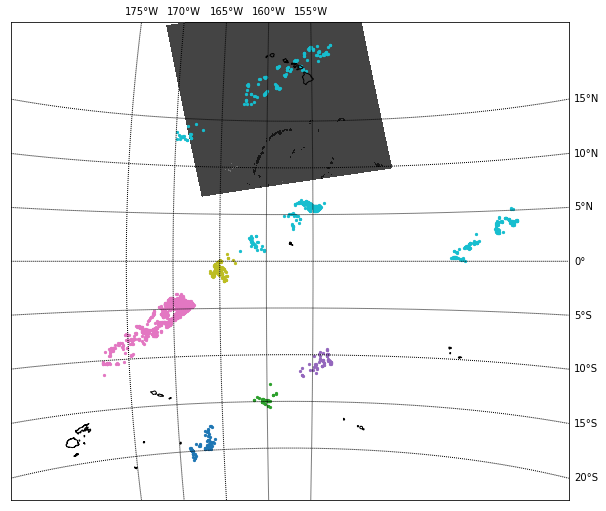

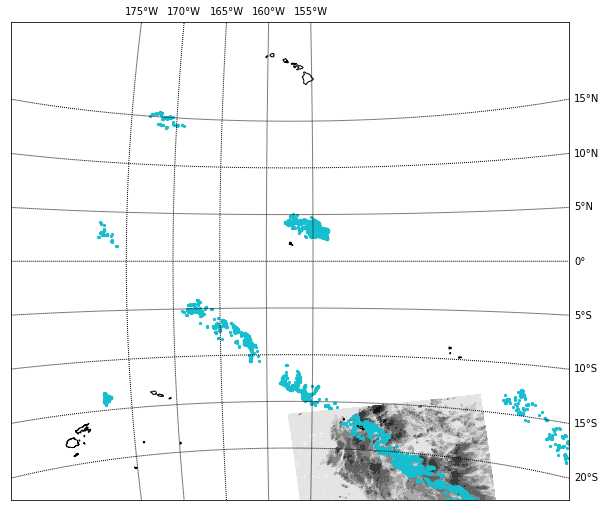

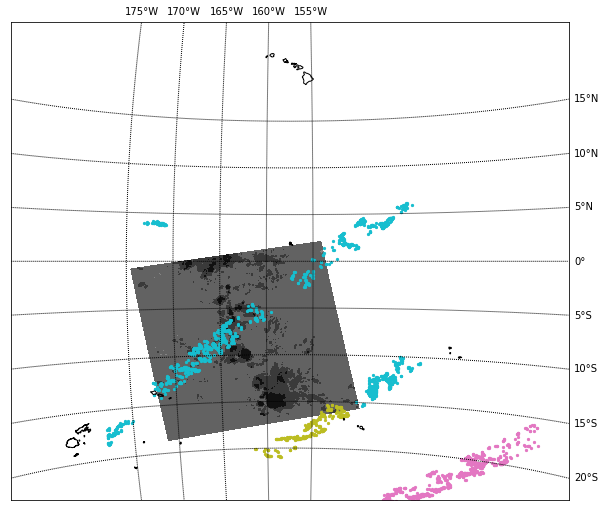

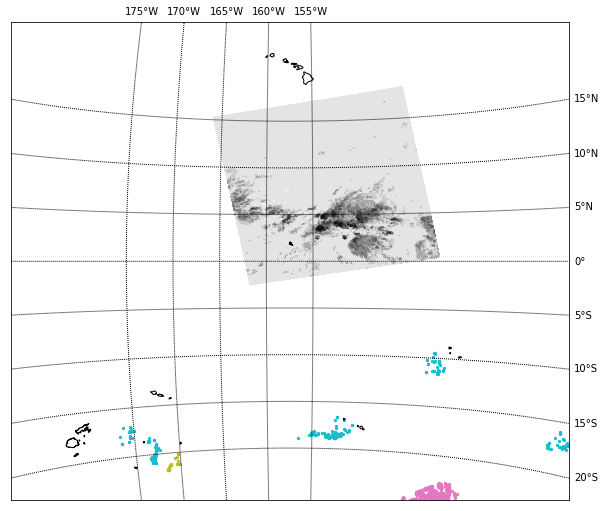

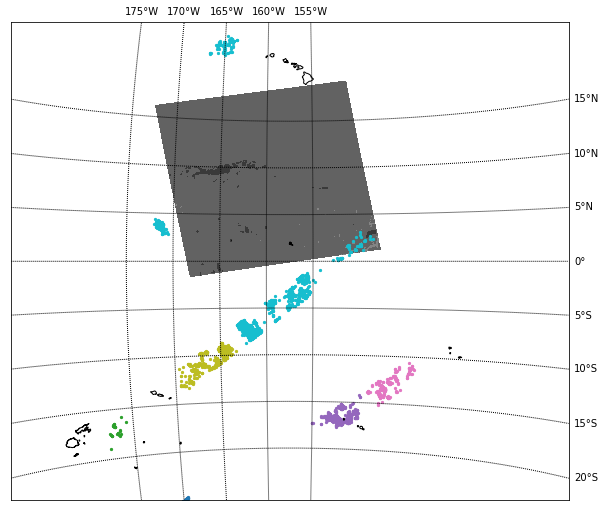

In [70]:
for file in glob.glob('MODIS/*.hdf'):
    df = SD.SD(file)
    modis_seconds = df.select('Scan_Start_Time')
    ref_date = datetime.datetime(1993,1,1)
    modis_date = ref_date+datetime.timedelta(seconds=int(modis_seconds[0,0]))
    subset_dblabels, subset_lat, subset_lon, subset_time = extract_day(modis_date.year,modis_date.month,modis_date.day,F)
    if subset_dblabels==[]:
        continue
    CR = df.select('Cirrus_Reflectance')
    lat = df.select('Latitude')
    lon = df.select('Longitude')

    #define region to plot
    bbox = [-22,22,-190,-125]
    parallels = np.arange(-20.,20,5.)
    verts = np.arange(-175.,-150,5.)

    #only look at clusters in NH and within ~5 hours of MODIS image
    inds = subset_dblabels[(abs(subset_time-modis_date.hour)<8)]
    uniqLabels = np.unique(inds)
    fig = plt.figure(figsize=(10,9))
    m = Basemap(projection='cass',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i',
            lon_0=(bbox[2]+bbox[3])/2,lat_0=(bbox[0]+bbox[1])/2)


    # Draw coastlines and put in parallels and meridians
    m.drawcoastlines()
    m.drawparallels(parallels,labels=[False,True,True,False]);
    m.drawmeridians(verts,labels=[False,True,True,False]);

    #plot the MODIS data
    m.contourf(lon[:],lat[:],CR[::5,5::5],latlon=True,cmap = plt.get_cmap('Greys'))
    cmap = plt.get_cmap('tab10')

    #plot the clusters
    for ii in range(len(uniqLabels)):
        m.scatter(np.array(subset_lon[subset_dblabels==uniqLabels[ii]]), 
                  np.array(subset_lat[subset_dblabels==uniqLabels[ii]]), 
                  latlon=True,marker='o',color=cmap(2*ii),s=5)
